In [392]:
import pandas as pd
import numpy as np
from os.path import join
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import log_loss
from lightgbm import LGBMClassifier
from scipy import stats



import seaborn as sns
import matplotlib.pyplot as plt



In [85]:
%ls data

sample_submission.csv  test.csv               train.csv


In [432]:
data = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

In [365]:
test["family_size"].value_counts()


2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [145]:
test.shape
data.shape

(26457, 20)

In [436]:
set(data.select_dtypes(exclude = "object").columns.to_list()) - set(["work_phone", "phone", "email"])

{'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'FLAG_MOBIL',
 'begin_month',
 'child_num',
 'credit',
 'family_size',
 'income_total',
 'index'}

In [437]:
def get_outlier_idx(df, col):

    q1 = np.percentile(data[col], 25)
    q3 = np.percentile(data[col], 75)
    
    iqr = q3 - q1

    lwr_bnd = q1 - 1.5*iqr
    upr_bnd = q3 + 1.5*iqr
    
    
    outlier_idx = df[(df[col] > upr_bnd) | (df[col] < lwr_bnd) ].index
    print(lwr_bnd, upr_bnd)
    
    return outlier_idx


def classify_child_type(x) :
    if x == 0 :
        return 1
    elif x <= 2 :
        return 2
    else :
        return 3
def classify_family(x) :
    if x <= 2 :
        return x
    elif x <= 4 :
        return 3
    else :
        return 4

def categorize(df):
    df_tmp = df.copy()
    cat_columns = df_tmp.select_dtypes(include="object").columns.to_list()
    df_tmp[cat_columns] = df_tmp[cat_columns].astype("category")
    return df_tmp
    
def preprocessing(train_data, test_data):
    
    data = train_data.copy()
    test = test_data.copy()
    
    dople_cols = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
                  'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                  'FLAG_MOBIL', 'work_phone', 'phone', 'email']



    # child_num 구분
    
#     data = data[data["child_num"] < 7] 
    
    data['child_type'] = data['child_num'].map(classify_child_type)
    test['child_type'] = test['child_num'].map(classify_child_type)
    # family_size 구분
    data = data[data["family_size"]  <= 7]
    data['family'] = data['family_size'].map(classify_family)
    test['family'] = test['family_size'].map(classify_family)

    # 중복인 처리
    data['account'] = data.groupby(dople_cols)['index'].transform(len)
    data['credit_mode'] = data.groupby(dople_cols)['credit'].transform(lambda x : x if len == 1 else stats.mode(x)[0][0]) # credit 변환 최빈값
    data['period_total'] = data.groupby(dople_cols)['begin_month'].transform(sum)
    data['period_avg'] = data['period_total'] / data['account']
    
    test['account'] = test.groupby(dople_cols)['index'].transform(len)
#     test['credit_mode'] = test.groupby(dople_cols)['credit'].transform(lambda x : x if len == 1 else stats.mode(x)[0][0]) # credit 변환 최빈값
    test['period_total'] = test.groupby(dople_cols)['begin_month'].transform(sum)
    test['period_avg'] = test['period_total'] / test['account']

    # 수입 컬럼 로그 처리
    data['income_log'] = data['income_total'].apply(lambda x : np.log(x))
    data['income_avail'] = np.log(data['income_total'] / data['account'])
    
    test['income_log'] = test['income_total'].apply(lambda x : np.log(x))
    test['income_avail'] = np.log(test['income_total'] / test['account'])

    # 나이(일수) >> 나이 + 10살 범위 그룹
    data['age'] = data['DAYS_BIRTH'].apply(lambda x : np.abs(x//365)-1)
    data['gene'] = data['age'].apply(lambda x : x//10)
    
    test['age'] = test['DAYS_BIRTH'].apply(lambda x : np.abs(x//365)-1)
    test['gene'] = test['age'].apply(lambda x : x//10)


    # 근속연수 치환bb
    data['work'] = data['DAYS_EMPLOYED'].apply(lambda x : np.abs(x//365))
    test['work'] = test['DAYS_EMPLOYED'].apply(lambda x : np.abs(x//365))

    # occyp_type 처리
    cond = data['income_type'] == 'Pensioner'
    data['occyp_type'] = data['occyp_type'].fillna(cond.map({True:'Unemployed', False: 'Unknown'}))

    cond = test['income_type'] == 'Pensioner'
    test['occyp_type'] = test['occyp_type'].fillna(cond.map({True:'Unemployed', False: 'Unknown'}))

    
    # days_employed
    data['DAYS_EMPLOYED'] = data['DAYS_EMPLOYED'].apply(lambda x : 1 if x > 0 else x)
    # family_size 이상치 처리
    data['adult'] = data['family_size'] - data['child_num']
    data = data[data['adult'] > 0]
    
    
    
    test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].apply(lambda x : 1 if x > 0 else x)
    # family_size 이상치 처리
    test['adult'] = test['family_size'] - test['child_num']
    
    data = data.drop(["index"], axis = 1)
    test = test.drop(["index"], axis = 1)
#     data = data[['credit_mode',
#        'gender','car','reality',
#        'adult', 'child_type',
#        'age',
#        'work',
#        'income_avail',
#        'period_avg',
#         "credit"]]
    
    
    data = data.reset_index(drop = True)

    return data, test



def preprocess(X_train, X_valid, X_test):
    
    
    X_train_tmp = X_train.copy()
    X_valid_tmp = X_valid.copy()
    X_test_tmp = X_test.copy()
    
    X_train_tmp = X_train_tmp.reset_index(drop = True)
    X_valid_tmp = X_valid_tmp.reset_index(drop = True)
    X_test_tmp = X_test_tmp.reset_index(drop = True)
    
    num_col = X_train_tmp.select_dtypes(exclude = "object").columns.to_list()
    cat_col = X_train_tmp.select_dtypes(include = "object").columns.to_list()    
    pre_scale_col = list(set(X_train_tmp.select_dtypes(exclude = "object").columns.to_list()) - set(["income_log",
                                                                                                     "income_avail",
                                                                                                     "work_phone", 
                                                                                                     "phone", 
                                                                                                     "email"]))

    
    sds = StandardScaler()
    rbs = RobustScaler()
    
#     X_train_tmp[pre_scale_col] = rbs.fit_transform(X_train_tmp[pre_scale_col])
#     X_valid_tmp[pre_scale_col] = rbs.transform(X_valid_tmp[pre_scale_col])
#     X_test_tmp[pre_scale_col] = rbs.transform(X_test_tmp[pre_scale_col])
    
    
    X_train_tmp[pre_scale_col] = sds.fit_transform(X_train_tmp[pre_scale_col])
    X_valid_tmp[pre_scale_col] = sds.transform(X_valid_tmp[pre_scale_col])
    X_test_tmp[pre_scale_col] = sds.transform(X_test_tmp[pre_scale_col])
    
    
    
    X_train_tmp = categorize(X_train_tmp)
    X_valid_tmp = categorize(X_valid_tmp)
    X_test_tmp = categorize(X_test_tmp)

    return X_train_tmp, X_valid_tmp, X_test_tmp

In [438]:
data = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")

# data = preprocessing(data)
# test = preprocessing_test(test)

data, test = preprocessing(data, test)

target_column = list(set(data.columns.to_list()) - set(test.columns.to_list()))

# ---
target_mode = data["credit_mode"].copy()
target = data["credit"].copy()

data = data.drop("credit_mode", axis = True)
data = data.drop("credit", axis = True)
# ---



# final feature

data = data.drop(["FLAG_MOBIL", 
                  "child_type", 
                  "gene",
                  "income_total",
                  "family"
                 ], axis = 1)
test = test.drop(["FLAG_MOBIL", 
                  "child_type", 
                  "gene",
                  "income_total", 
                  "family"
                 ], axis = 1)

In [439]:
data

,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,...,family_size,begin_month,account,period_total,period_avg,income_log,income_avail,age,work,adult
0,F,N,N,0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,...,2.0,-6.0,5,-166.0,-33.200000,12.218495,10.609057,38,13,2.0
1,F,N,Y,1,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,...,3.0,-5.0,9,-67.0,-7.444444,12.419166,10.221941,31,5,2.0
2,M,Y,Y,0,Working,Higher education,Married,House / apartment,-19087,-4434,...,2.0,-22.0,6,-172.0,-28.666667,13.017003,11.225243,52,13,2.0
3,F,N,Y,0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,...,2.0,-37.0,2,-89.0,-44.500000,12.218495,11.525348,41,6,2.0
4,F,Y,Y,0,State servant,Higher education,Married,House / apartment,-15037,-2105,...,2.0,-26.0,1,-26.0,-26.000000,11.967181,11.967181,41,6,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26440,F,N,N,2,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,...,4.0,-2.0,5,-118.0,-23.600000,12.323856,10.714418,33,6,2.0
26441,F,N,Y,1,Working,Higher education,Separated,House / apartment,-15291,-2475,...,2.0,-47.0,1,-47.0,-47.000000,12.100712,12.100712,41,7,1.0
26442,F,Y,N,0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,...,2.0,-25.0,1,-25.0,-25.000000,12.586220,12.586220,27,6,2.0
26443,M,N,Y,0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,...,1.0,-59.0,1,-59.0,-59.000000,12.049419,12.049419,27,1,1.0


#### function test

In [440]:
from sklearn.model_selection import train_test_split

xtrain, xvalid, ytrain, ytest = train_test_split(data, target, test_size=0.3,
                                                 stratify= target, random_state= 42, shuffle= True)


xtest = test.copy()

# print(xtrain.shape, xvalid.shape, xtest.shape)
xtrain, xvalid, xtest = preprocess(xtrain, xvalid, xtest)
print(xtrain.shape, xvalid.shape, xtest.shape)


(18511, 24) (7934, 24) (10000, 24)


In [442]:
pd.options.display.max_columns = None
xtrain

,gender,car,reality,child_num,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,occyp_type,family_size,begin_month,account,period_total,period_avg,income_log,income_avail,age,work,adult
0,F,N,Y,-0.586808,Commercial associate,Secondary / secondary special,Widow,House / apartment,-0.142416,-0.243727,0,0,0,Private service staff,-1.323279,1.459002,-1.131451,1.233642,2.212338,11.967181,11.967181,0.153355,-0.450923,-1.812444
1,M,N,N,0.801890,Working,Secondary / secondary special,Married,Rented apartment,0.817981,0.898705,0,0,0,Laborers,0.902244,-0.415148,-1.131451,0.951859,-0.631335,11.630709,11.630709,-0.800063,-0.469728,0.551741
2,F,N,Y,-0.586808,Pensioner,Secondary / secondary special,Married,House / apartment,-0.833266,0.928658,0,1,0,Unemployed,-0.210518,1.035807,-0.591587,0.870050,1.111561,11.630709,10.532096,0.846750,2.213935,0.551741
3,M,Y,Y,-0.586808,Working,Secondary / secondary special,Married,House / apartment,1.066630,0.682284,0,0,0,Unknown,-0.210518,1.035807,-0.591587,0.779153,0.805790,11.967181,10.868568,-1.060086,-0.467042,0.551741
4,M,N,N,-0.586808,Pensioner,Secondary / secondary special,Married,House / apartment,-1.810050,0.928658,0,0,0,Unemployed,-0.210518,-1.080169,-0.051723,-0.184365,-0.502911,11.967181,10.357743,1.800169,2.213935,0.551741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18506,F,N,N,-0.586808,Working,Secondary / secondary special,Separated,House / apartment,-0.120092,-0.229806,0,1,0,Unknown,-1.323279,0.128960,1.297936,-1.384217,-0.264409,11.707670,9.405084,0.153355,-0.450923,-1.812444
18507,F,Y,Y,-0.586808,Working,Secondary / secondary special,Civil marriage,House / apartment,0.832231,0.642206,0,0,0,Sales staff,-0.210518,0.793981,0.488141,-0.984266,-0.827902,12.100712,10.154802,-0.800063,-0.467042,0.551741
18508,M,N,Y,-0.586808,Working,Secondary / secondary special,Civil marriage,House / apartment,-0.240736,0.156208,0,0,0,Security staff,-0.210518,0.914894,-0.591587,0.942769,1.356178,11.877569,10.778956,0.240030,-0.456296,0.551741
18509,M,Y,Y,-0.586808,Commercial associate,Higher education,Single / not married,House / apartment,-0.561106,-0.666022,0,0,0,Drivers,-1.323279,0.189417,-1.131451,1.042756,0.285979,11.813030,11.813030,0.586727,-0.442864,-1.812444


In [411]:
xtest.describe()

,child_num,DAYS_BIRTH,DAYS_EMPLOYED,work_phone,phone,email,family_size,begin_month,account,period_total,period_avg,income_log,income_avail,age,work,adult
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.016859,-0.013096,-0.001942,0.004407,-0.005922,-0.027175,0.015039,-0.008421,-0.701935,0.631136,-0.014203,12.010160,11.250752,0.013047,0.000807,0.003250
std,1.012502,0.996893,0.994860,1.002927,0.997429,0.960975,0.999563,0.988376,0.467472,0.480775,1.175184,0.479570,0.756867,0.996882,1.000704,1.000232
min,-0.586808,-2.181717,-5.678718,-0.539986,-0.653113,-0.321183,-1.323279,-2.047472,-1.131451,-1.456935,-3.108082,10.203592,8.817298,-2.013504,-0.469728,-6.540815
25%,-0.586808,-0.835463,-0.401930,-0.539986,-0.653113,-0.321183,-0.210518,-0.777887,-1.131451,0.379202,-0.814798,11.707670,10.714418,-0.800063,-0.461669,0.551741
50%,-0.586808,0.085334,0.262942,-0.539986,-0.653113,-0.321183,-0.210518,0.068504,-0.861519,0.751883,0.033718,11.967181,11.274034,-0.106668,-0.453610,0.551741
75%,0.801890,0.813707,0.755268,-0.539986,1.531128,-0.321183,0.902244,0.854438,-0.591587,0.979128,0.836367,12.323856,11.813030,0.846750,-0.429433,0.551741
max,6.356683,2.013016,0.928658,1.851899,1.531128,3.113490,5.353288,1.579915,2.917528,1.251822,2.395801,14.269766,13.933294,2.146866,2.213935,0.551741


---

### modeling

In [ ]:
accuracy_score()

#### model - credit by mode

In [466]:
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, recall_score, log_loss, accuracy_score
# from lightgbm import plot_importance
####


le = LabelEncoder()
le.fit_transform(target)

n_splits = 5
skf = StratifiedKFold(n_splits, shuffle= True, random_state= 42)

# cm_oof_pred = np.zeros([test.shape[0], le.classes_.shape[0]])
cm_logloss_score = []
cm_accuracy = []


for i, (trn_idx, val_idx) in enumerate(skf.split(data, target)):
    X_train, y_train = data.iloc[trn_idx,:], target[trn_idx]
    X_valid, y_valid = data.iloc[val_idx,:], target[val_idx]
    y_train_mode = target_mode[trn_idx]
    y_valid_mode = target_mode[val_idx]


    X_train, X_valid, X_test = preprocess(X_train, X_valid, test)

    cm_model = LGBMClassifier(n_estimators = 1000,
                           objective= "multiclass",
                           n_jobs= -1,
                           random_state   = 42)

    cm_model.fit(X_train, y_train_mode,
              eval_set=[[X_train, y_train_mode], [X_valid, y_valid_mode]],
              eval_metric='multi_logloss',
            
              early_stopping_rounds=100,
              verbose=100)
    
    cm_logloss_score.append(log_loss(y_valid_mode, cm_model.predict_proba(X_valid)))
#     cm_accuracy.append(accuracy_score(y_valid_mode, cm_model.predict_proba(X_valid), average = "macro"))
#     cm_oof_pred += cm_model.predict_proba(X_test) / n_splits
    
    print("Fold {0}, train logloss: {1}, valid logloss: {2}".format(i, 
                                                                    log_loss(y_train_mode, cm_model.predict_proba(X_train)),
                                                                    log_loss(y_valid_mode, cm_model.predict_proba(X_valid))))
    
    cm_cv_loss = np.mean(cm_logloss_score)
#     cm_cv_accuracy = np.mean(cm_accuracy)
                       
    
print("Cross Validation Score : {:.4f}".format(np.mean(cm_cv_loss)))
                       
# print("Cross Validation Score : {:.4f}".format(np.mean(cm_cv_accuracy)))   

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.432247	valid_1's multi_logloss: 0.517163
[200]	training's multi_logloss: 0.290034	valid_1's multi_logloss: 0.399728
[300]	training's multi_logloss: 0.202492	valid_1's multi_logloss: 0.327498
[400]	training's multi_logloss: 0.146754	valid_1's multi_logloss: 0.28007
[500]	training's multi_logloss: 0.106605	valid_1's multi_logloss: 0.247212
[600]	training's multi_logloss: 0.0784093	valid_1's multi_logloss: 0.225693
[700]	training's multi_logloss: 0.0578983	valid_1's multi_logloss: 0.212956
[800]	training's multi_logloss: 0.0428108	valid_1's multi_logloss: 0.20476
[900]	training's multi_logloss: 0.0312761	valid_1's multi_logloss: 0.199175
[1000]	training's multi_logloss: 0.0236174	valid_1's multi_logloss: 0.195882
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0236174	valid_1's multi_logloss: 0.195882
Fold 0, train logloss: 0.02361742240135969, valid logloss: 

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.43915	valid_1's multi_logloss: 0.518545
[200]	training's multi_logloss: 0.287231	valid_1's multi_logloss: 0.394142
[300]	training's multi_logloss: 0.200061	valid_1's multi_logloss: 0.324559
[400]	training's multi_logloss: 0.143729	valid_1's multi_logloss: 0.279029
[500]	training's multi_logloss: 0.103169	valid_1's multi_logloss: 0.247357
[600]	training's multi_logloss: 0.0756196	valid_1's multi_logloss: 0.224884
[700]	training's multi_logloss: 0.0561348	valid_1's multi_logloss: 0.214531
[800]	training's multi_logloss: 0.0419046	valid_1's multi_logloss: 0.206387
[900]	training's multi_logloss: 0.0314071	valid_1's multi_logloss: 0.202296
[1000]	training's multi_logloss: 0.023537	valid_1's multi_logloss: 0.201316
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.023537	valid_1's multi_logloss: 0.201316
Fold 1, train logloss: 0.02353701076164218, valid logloss: 0.20131636576996487
Training until validation scores don't impr

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.433585	valid_1's multi_logloss: 0.505228
[200]	training's multi_logloss: 0.288852	valid_1's multi_logloss: 0.386414
[300]	training's multi_logloss: 0.202248	valid_1's multi_logloss: 0.319706
[400]	training's multi_logloss: 0.145627	valid_1's multi_logloss: 0.276594
[500]	training's multi_logloss: 0.107046	valid_1's multi_logloss: 0.245326
[600]	training's multi_logloss: 0.0793563	valid_1's multi_logloss: 0.224562
[700]	training's multi_logloss: 0.0582003	valid_1's multi_logloss: 0.211877
[800]	training's multi_logloss: 0.0435677	valid_1's multi_logloss: 0.202001
[900]	training's multi_logloss: 0.0322419	valid_1's multi_logloss: 0.196746
[1000]	training's multi_logloss: 0.0235355	valid_1's multi_logloss: 0.194546
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0235355	valid_1's multi_logloss: 0.194546
Fold 2, train logloss: 0.02353552536969528, valid logloss: 0.19454626809290992
Training until validation scores don't i

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.435489	valid_1's multi_logloss: 0.499421
[200]	training's multi_logloss: 0.29061	valid_1's multi_logloss: 0.387431
[300]	training's multi_logloss: 0.203069	valid_1's multi_logloss: 0.318991
[400]	training's multi_logloss: 0.146841	valid_1's multi_logloss: 0.277117
[500]	training's multi_logloss: 0.106843	valid_1's multi_logloss: 0.249285
[600]	training's multi_logloss: 0.0769359	valid_1's multi_logloss: 0.230337
[700]	training's multi_logloss: 0.0570923	valid_1's multi_logloss: 0.219666
[800]	training's multi_logloss: 0.0430156	valid_1's multi_logloss: 0.21331
[900]	training's multi_logloss: 0.0314088	valid_1's multi_logloss: 0.208892
[1000]	training's multi_logloss: 0.0234171	valid_1's multi_logloss: 0.208477
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.0234171	valid_1's multi_logloss: 0.208477
Fold 3, train logloss: 0.023417109703561374, valid logloss: 0.2084772807459321
Training until validation scores don't imp

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.434812	valid_1's multi_logloss: 0.499561
[200]	training's multi_logloss: 0.287239	valid_1's multi_logloss: 0.382556
[300]	training's multi_logloss: 0.200859	valid_1's multi_logloss: 0.311965
[400]	training's multi_logloss: 0.146794	valid_1's multi_logloss: 0.26838
[500]	training's multi_logloss: 0.1059	valid_1's multi_logloss: 0.237384
[600]	training's multi_logloss: 0.0780804	valid_1's multi_logloss: 0.216994
[700]	training's multi_logloss: 0.0577742	valid_1's multi_logloss: 0.203619
[800]	training's multi_logloss: 0.0421151	valid_1's multi_logloss: 0.194816
[900]	training's multi_logloss: 0.0309627	valid_1's multi_logloss: 0.19063
[1000]	training's multi_logloss: 0.022916	valid_1's multi_logloss: 0.187605
Did not meet early stopping. Best iteration is:
[1000]	training's multi_logloss: 0.022916	valid_1's multi_logloss: 0.187605
Fold 4, train logloss: 0.022916014751335003, valid logloss: 0.18760485078380598
Cross Validation Score : 0.1976


In [459]:
cm_logloss_score

[]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

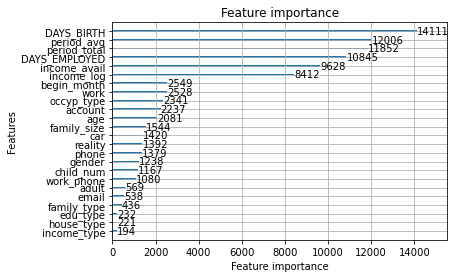

In [450]:
plot_importance(model)

#### model - original credit

array([1, 1, 2, ..., 2, 2, 2])

In [443]:
# from lightgbm import LGBMClassifier
# from sklearn.model_selection import StratifiedKFold
# from sklearn.metrics import f1_score, recall_score, log_loss
# from lightgbm import plot_importance
####


le = LabelEncoder()
le.fit_transform(target)

n_splits = 10
skf = StratifiedKFold(n_splits, shuffle= True, random_state= 42)

oof_pred = np.zeros([test.shape[0], le.classes_.shape[0]])
logloss_score = []


for i, (trn_idx, val_idx) in enumerate(skf.split(data, target)):
    X_train, y_train = data.iloc[trn_idx,:], target[trn_idx]
    X_valid, y_valid = data.iloc[val_idx,:], target[val_idx]
    y_train_mode = target_mode[trn_idx]
    y_valid_mode = target_mode[val_idx]


    X_train, X_valid, X_test = preprocess(X_train, X_valid, test)

    model = LGBMClassifier(n_estimators = 1000,
                           objective= "multiclass",
                           n_jobs= -1,
                           random_state   = 42)

    model.fit(X_train, y_train,
              eval_set=[[X_train, y_train], [X_valid, y_valid]],
              eval_metric='multi_logloss',
              early_stopping_rounds=100,
              verbose=100)
    
    logloss_score.append(log_loss(y_valid, model.predict_proba(X_valid)))
    oof_pred += model.predict_proba(X_test) / n_splits
    
    print("Fold {0}, train logloss: {1}, valid logloss: {2}".format(i, 
                                                                    log_loss(y_train, model.predict_proba(X_train)),
                                                                    log_loss(y_valid, model.predict_proba(X_valid))))
    
    cv_loss = np.mean(logloss_score)
    
print("Cross Validation Score : {:.4f}".format(np.mean(cv_loss)))

/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.622299	valid_1's multi_logloss: 0.725646
[200]	training's multi_logloss: 0.528567	valid_1's multi_logloss: 0.701967
[300]	training's multi_logloss: 0.462629	valid_1's multi_logloss: 0.695366
[400]	training's multi_logloss: 0.40984	valid_1's multi_logloss: 0.696247
Early stopping, best iteration is:
[325]	training's multi_logloss: 0.448784	valid_1's multi_logloss: 0.694517
Fold 0, train logloss: 0.44878365984605983, valid logloss: 0.6945166020101723
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.621534	valid_1's multi_logloss: 0.728371
[200]	training's multi_logloss: 0.527475	valid_1's multi_logloss: 0.710028
[300]	training's multi_logloss: 0.460974	valid_1's multi_logloss: 0.704094
[400]	training's multi_logloss: 0.407165	valid_1's multi_logloss: 0.704681
Early stopping, best iteration is:
[359]	training's multi_logloss: 0.427704	valid_1's multi_logloss: 0.702837
Fold 1, train logloss: 0.42770430768279233, valid logloss: 0.7028367377272413
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.618655	valid_1's multi_logloss: 0.734984
[200]	training's multi_logloss: 0.526893	valid_1's multi_logloss: 0.718974
[300]	training's multi_logloss: 0.46019	valid_1's multi_logloss: 0.712715
[400]	training's multi_logloss: 0.407994	valid_1's multi_logloss: 0.713701
Early stopping, best iteration is:
[318]	training's multi_logloss: 0.449167	valid_1's multi_logloss: 0.712448
Fold 2, train logloss: 0.44916701015163724, valid logloss: 0.7124481311514885
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.619492	valid_1's multi_logloss: 0.737368
[200]	training's multi_logloss: 0.526672	valid_1's multi_logloss: 0.71445
[300]	training's multi_logloss: 0.459328	valid_1's multi_logloss: 0.711168
Early stopping, best iteration is:
[264]	training's multi_logloss: 0.481203	valid_1's multi_logloss: 0.710193
Fold 3, train logloss: 0.4812032773828212, valid logloss: 0.7101930452782024
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.622549	valid_1's multi_logloss: 0.729288
[200]	training's multi_logloss: 0.528407	valid_1's multi_logloss: 0.715284
[300]	training's multi_logloss: 0.461653	valid_1's multi_logloss: 0.709613
Early stopping, best iteration is:
[281]	training's multi_logloss: 0.472915	valid_1's multi_logloss: 0.709104
Fold 4, train logloss: 0.47291545421908365, valid logloss: 0.7091043897110941
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.61703	valid_1's multi_logloss: 0.742583
[200]	training's multi_logloss: 0.524146	valid_1's multi_logloss: 0.724614
[300]	training's multi_logloss: 0.458538	valid_1's multi_logloss: 0.720447
[400]	training's multi_logloss: 0.40619	valid_1's multi_logloss: 0.723996
Early stopping, best iteration is:
[312]	training's multi_logloss: 0.451182	valid_1's multi_logloss: 0.719889
Fold 5, train logloss: 0.45118156127709474, valid logloss: 0.7198891399448136
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.615667	valid_1's multi_logloss: 0.733637
[200]	training's multi_logloss: 0.52357	valid_1's multi_logloss: 0.718112
[300]	training's multi_logloss: 0.456092	valid_1's multi_logloss: 0.71531
[400]	training's multi_logloss: 0.403368	valid_1's multi_logloss: 0.717295
Early stopping, best iteration is:
[315]	training's multi_logloss: 0.447495	valid_1's multi_logloss: 0.714715
Fold 6, train logloss: 0.44749462218057434, valid logloss: 0.7147149621271711
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.62076	valid_1's multi_logloss: 0.72896
[200]	training's multi_logloss: 0.527191	valid_1's multi_logloss: 0.714807
[300]	training's multi_logloss: 0.460193	valid_1's multi_logloss: 0.714302
Early stopping, best iteration is:
[259]	training's multi_logloss: 0.485033	valid_1's multi_logloss: 0.712115
Fold 7, train logloss: 0.48503279645604225, valid logloss: 0.7121153994181951
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.618011	valid_1's multi_logloss: 0.735148
[200]	training's multi_logloss: 0.526176	valid_1's multi_logloss: 0.715185
[300]	training's multi_logloss: 0.458559	valid_1's multi_logloss: 0.710932
Early stopping, best iteration is:
[292]	training's multi_logloss: 0.463099	valid_1's multi_logloss: 0.710568
Fold 8, train logloss: 0.46309879198488824, valid logloss: 0.7105679555793963
Training until validation scores don't improve for 100 rounds


/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1286: UserWarning: Overriding the parameters from Reference Dataset.
  warnings.warn('Overriding the parameters from Reference Dataset.')
/opt/anaconda3/lib/python3.7/site-packages/lightgbm/basic.py:1098: UserWarning: categorical_column in param dict is overridden.
  warnings.warn('{} in param dict is overridden.'.format(cat_alias))


[100]	training's multi_logloss: 0.618768	valid_1's multi_logloss: 0.721531
[200]	training's multi_logloss: 0.5255	valid_1's multi_logloss: 0.707045
[300]	training's multi_logloss: 0.459568	valid_1's multi_logloss: 0.70279
Early stopping, best iteration is:
[275]	training's multi_logloss: 0.474571	valid_1's multi_logloss: 0.701425
Fold 9, train logloss: 0.47457124509943627, valid logloss: 0.7014245145737251
Cross Validation Score : 0.7088


In [377]:
oof_pred

array([[0.05254576, 0.08635782, 0.86109642],
       [0.22433909, 0.13822351, 0.6374374 ],
       [0.07998912, 0.14929009, 0.77072079],
       ...,
       [0.03941338, 0.1432123 , 0.81737432],
       [0.06376496, 0.19277466, 0.74346039],
       [0.04010016, 0.18046999, 0.77942985]])

In [390]:
oof_pred

array([[0.07337376, 0.08478166, 0.84184458],
       [0.20533644, 0.12125568, 0.67340788],
       [0.10193346, 0.14723459, 0.75083195],
       ...,
       [0.04069236, 0.17450025, 0.78480739],
       [0.05825978, 0.18547557, 0.75626466],
       [0.03517328, 0.19169755, 0.77312917]])

In [331]:
logloss_score

[0.7171828077238683,
 0.711941327519137,
 0.7104629170443783,
 0.7114142014218908,
 0.7169287559391796]

In [342]:
logloss_score

[0.7204685446162704,
 0.7107461362094222,
 0.7099044187269007,
 0.7107747289129934,
 0.7168184343104218]

In [382]:
logloss_score

[0.7058927280383122,
 0.7221036963778241,
 0.7154774825277908,
 0.7075374907344579,
 0.7051578944801312,
 0.6895243817546279,
 0.7080543655729757,
 0.6994327249845504,
 0.7089763557400542,
 0.6984048920528949]

In [419]:
sub = pd.read_csv("./data/sample_submission.csv")
sub.iloc[:,[1,2,3]] = oof_pred

sub.to_csv("./data/sub.csv", index= False)
pd.read_csv("./data/sub.csv")

,index,0,1,2
0,26457,0.066625,0.114831,0.818544
1,26458,0.218042,0.128030,0.653928
2,26459,0.089860,0.150471,0.759669
3,26460,0.133186,0.127393,0.739420
4,26461,0.085513,0.413836,0.500650
...,...,...,...,...
9995,36452,0.108016,0.172585,0.719399
9996,36453,0.111594,0.191567,0.696839
9997,36454,0.041364,0.188242,0.770394
9998,36455,0.056631,0.157496,0.785873


,index,0,1,2
0,26457,0.052546,0.086358,0.861096
1,26458,0.224339,0.138224,0.637437
2,26459,0.079989,0.149290,0.770721
3,26460,0.117476,0.145098,0.737426
4,26461,0.080739,0.423164,0.496097
...,...,...,...,...
9995,36452,0.101931,0.185732,0.712337
9996,36453,0.113874,0.202708,0.683418
9997,36454,0.039413,0.143212,0.817374
9998,36455,0.063765,0.192775,0.743460


<AxesSubplot:xlabel='importance', ylabel='feature'>

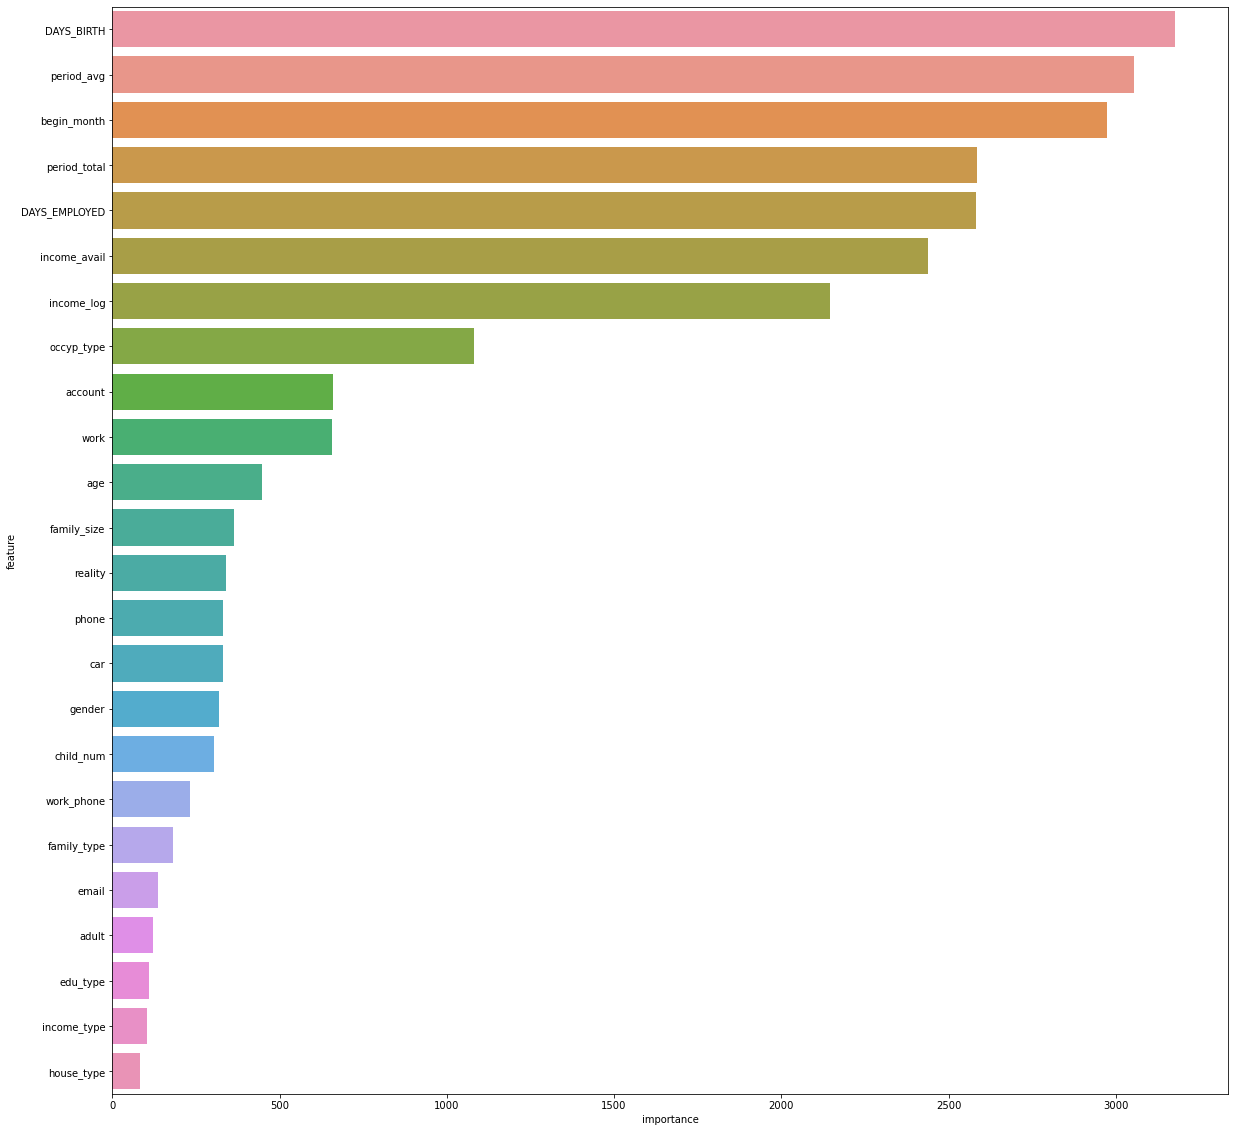

In [420]:
feature_importance = pd.DataFrame([model.feature_importances_, model.feature_name_], index= ["importance", "feature"]).T
feature_importance = feature_importance.sort_values("importance", ascending = False)
plt.figure(figsize = (20,20))
sns.barplot(data = feature_importance, x = "importance", y = "feature")

<AxesSubplot:xlabel='importance', ylabel='feature'>

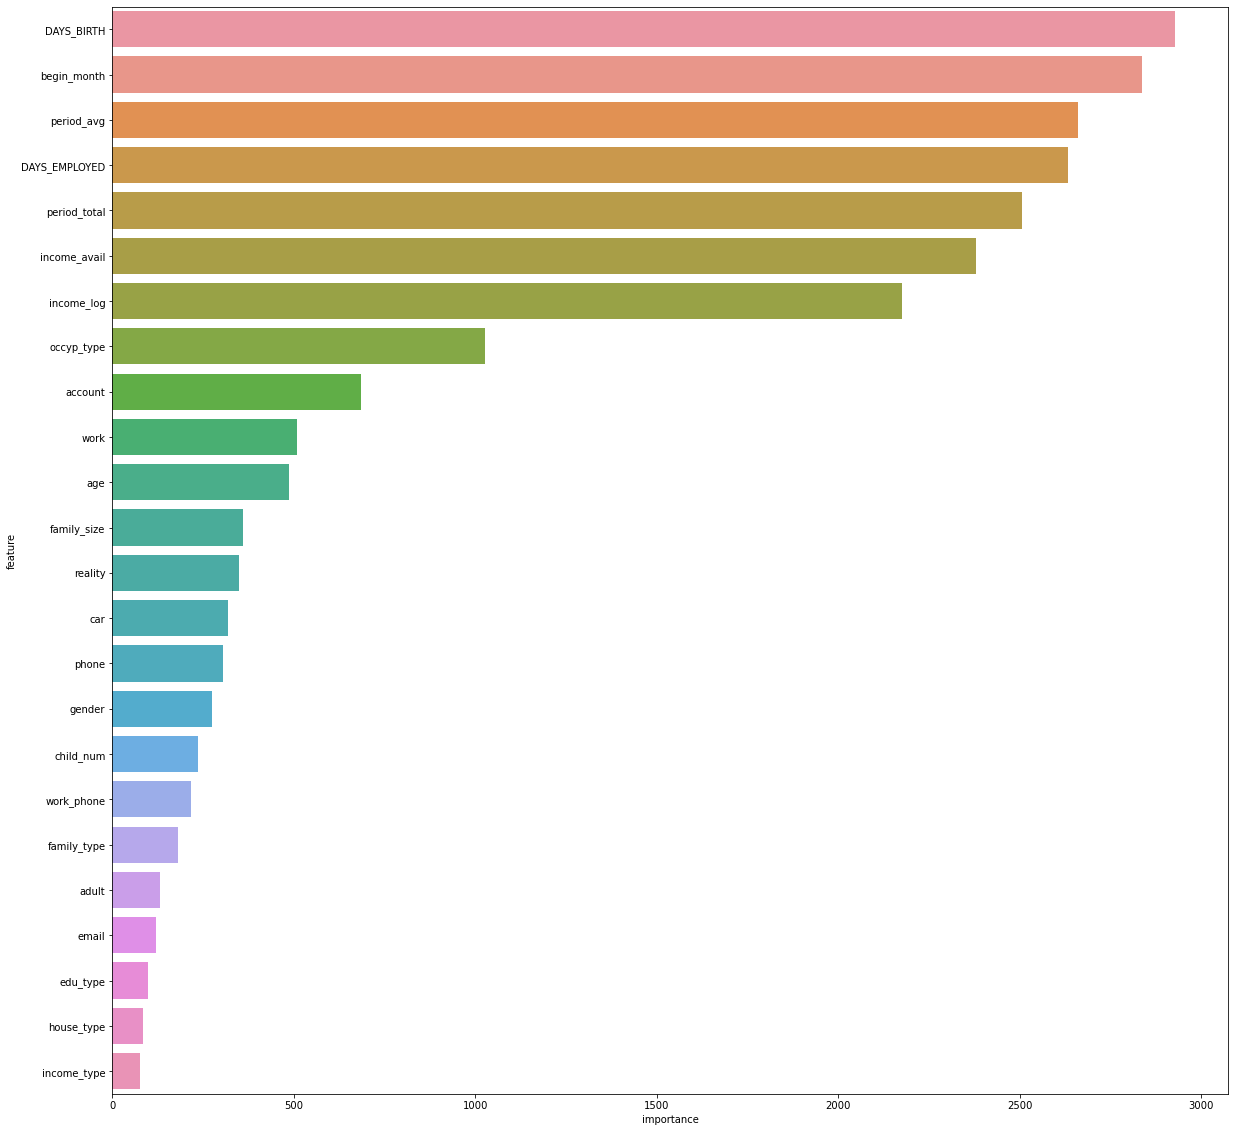

In [375]:
feature_importance = pd.DataFrame([model.feature_importances_, model.feature_name_], index= ["importance", "feature"]).T
feature_importance = feature_importance.sort_values("importance", ascending = False)
plt.figure(figsize = (20,20))
sns.barplot(data = feature_importance, x = "importance", y = "feature")

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

<Figure size 1440x1440 with 0 Axes>

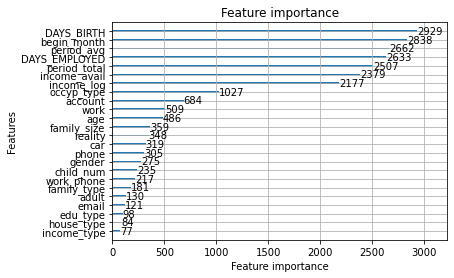

In [360]:
plt.figure(figsize = (20,20))
plot_importance(model)

In [307]:
feature_importance

["FLAG_MOBIL", "child_type", "gene","income_total"]

,importance,feature
9,2585,DAYS_BIRTH
22,2559,period_avg
17,2541,begin_month
10,2288,DAYS_EMPLOYED
21,2231,period_total
24,2089,income_avail
4,1821,income_total
15,943,occyp_type
20,589,account
27,499,work


data -> Train, Validation, Test 

K-Fold Cross Validation
* Out-of-Fold Ensemble
    KFold 교차 검증에서의 각 Fold에 대한 예측 값을 앙상블하며 동시에 모델 검증을 할 수 있기 때문에 OOF로 진행
    
    대회 데이터이기 때분에 test 데이터는 별도로 제공되며, 기존의 데이터를 train 과 validation으로 나누어서 모델을 평가
    train과 validation data는 K-Fold 방식을 이용하여 데이터를 나누고, k-1개로 모델을 학습하고 나머지 1개로 쪼갠 데이터를 모든 fold에 대해 검증하고 
    각 fold 마다 예측된 확률들을 더하여 k개로 나누어서 최종 class를 예측